In [ ]:
D:\Documents\Course\AI Agents\Projects\ai_agents\Scripts\python.exe

In [2]:
import sys
sys.path.append(r"D:\Documents\Course\AI Agents\Projects\ai_agents\Lib\site-packages")  # For packages

In [2]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.tools import Tool
from langchain.tools.retriever import create_retriever_tool

def load_health_retriever_tool():
    # Load the same embeddings you used during ingestion
    embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    
    # Load the persisted Chroma vector store
    vectorstore = Chroma(
        persist_directory="chroma_medlineplus",
        embedding_function=embedding_model
    )
    
    # Convert to retriever
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    
    # Create tool
    retriever_tool = create_retriever_tool(
        retriever,
        name="medlineplus_health_retriever",
        description="Search for health-related topics from MedlinePlus like symptoms, diseases, treatments, and body systems. Use this tool for any health-related question."
    )
    
    return retriever_tool


In [3]:
retriever_tool = load_health_retriever_tool()

In [4]:
retriever_tool.invoke("What are symptoms of diabetes")

'is when you throw up. What causes nausea and vomiting? Nausea and vomiting can be symptoms of many different conditions, including: Morning sickness during pregnancy Gastroenteritis (infection of your intestines) and other infections Migraines Motion sickness Food poisoning Medicines, including those for cancer chemotherapy GERD (reflux) and ulcers Intestinal obstruction When do I need to see a health care provider for nausea and vomiting? Nausea and vomiting are common. They are usually not serious. However, you should contact your health care provider immediately if you have: A reason to think that your vomiting is from poisoning Vomited for longer than 24 hours Blood in the vomit Severe abdominal pain Severe headache and stiff neck Signs of dehydration , such as dry mouth, infrequent urination or dark urine How is the cause of nausea and vomiting diagnosed? Your health care provider will take your medical history, ask about your symptoms and do a physical exam. The provider will\n\

In [5]:
from langchain.tools import tool
from langchain_community.document_loaders import PyPDFLoader

In [6]:
@tool
def extract_report_text(file_path: str) -> str:
    """Extracts and cleans text from medical PDF reports."""
    loader = PyPDFLoader(file_path)
    pages = loader.load()
    return "\n".join([p.page_content for p in pages])

In [7]:
ans = extract_report_text.invoke("001000000000084296_001_250571278_C10_117_1.pdf")

In [8]:
print(ans)

Clinical Chemistry ReportPDF: 01-May-2025 11:30:46
MBBS, DABP (AP and 
Cytopathology), FIAC
MBBS, DABP (AP, CP and 
Hematopathology)
MBBS, DABP (AP, CP, 
Cytopathology)
Dr. Asif Loya Dr. Asad Hayat Ahmad Dr. Umer Nisar Sheikh
Electronically verified report, no signature(s) required.
Department of Pathology
Shaukat Khanum Memorial Cancer Hospital & Research Centre
Johar Town, Lahore, Pakistan. Phone: +92-42-35905000, 111-155-555, Fax: 042-35945198
Email: info@skm.org.pk, Website: www.shaukatkhanum.org.pk
Page 1 of 1
Chemistry I - Serum
CREATININE
eGFR
GLUCOSE (FASTING)*
TEST(s)
0.60 - 1.10
>60
70 - 99
NORMAL 01-MAY-2025 
11:26:37
mg/dL
mL/min/1.73 
m²
mg/dL
UNIT(s)
021RCH25006893
0.66
94.87
111
001-80003010010MRNO :
: 13- JUL- 1975Date of Birth
Samina AmjadName :
Phone 92 0300 8655387:
In-house Consultant :
Report Destination Cc 10, People Colony, 
Faisalabad
:
Ordered By Raees Ahmad:
Requested : 01-MAY-2025 08:36:18
Specimen Received : 01-MAY-2025 10:32:12
Reported : 01-MAY-2025 11:26:

In [9]:
from langchain.prompts import PromptTemplate

extract_agent_prompt = PromptTemplate.from_template(
    """You are a medical report extractor agent.

Your job is to use the available tools to extract and return **all detailed textual content** from the provided medical report. Do **not summarize**, do **not interpret**, and do **not leave out** any information. Simply extract **everything as-is**, preserving the structure, headings, values, and important formatting as much as possible.

You have access to the following tools:
{tools}

Use the following format:

Question: the input question you must answer  
Thought: you should always think about what to do  
Action: the action to take, should be one of [{tool_names}]  
Action Input: the input to the action  
Observation: the result of the action  
... (this Thought/Action/Action Input/Observation can repeat N times)  
Thought: I now know the final answer  
Final Answer: the complete extracted report content

Begin!

Question: {input}  
{agent_scratchpad}
"""
)




In [6]:
import os
from dotenv import load_dotenv
load_dotenv()
api = os.getenv("GROQ_API_KEY")



In [7]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = 'deepseek-r1-distill-llama-70b')

In [8]:
llm.invoke("Hello buddy").content

AuthenticationError: Error code: 401 - {'error': {'message': 'Invalid API Key', 'type': 'invalid_request_error', 'code': 'invalid_api_key'}}

In [13]:
from langchain.agents import create_react_agent, AgentExecutor
agent = create_react_agent(
    llm=llm,
    tools=[extract_report_text],
    prompt=extract_agent_prompt
)

In [14]:
extract_agent_executor = AgentExecutor(agent=agent, tools=[extract_report_text], verbose=True)

In [15]:
result = extract_agent_executor.invoke({
    "input": "Return the full clean report text from 001000000000084296_001_250571278_C10_117_1.pdf"
})
print(result["output"])  # Should show entire extracted text







> Entering new AgentExecutor chain...
Thought: I need to extract the text from the PDF file.
Action: extract_report_text
Action Input: 001000000000084296_001_250571278_C10_117_1.pdfClinical Chemistry ReportPDF: 01-May-2025 11:30:46
MBBS, DABP (AP and 
Cytopathology), FIAC
MBBS, DABP (AP, CP and 
Hematopathology)
MBBS, DABP (AP, CP, 
Cytopathology)
Dr. Asif Loya Dr. Asad Hayat Ahmad Dr. Umer Nisar Sheikh
Electronically verified report, no signature(s) required.
Department of Pathology
Shaukat Khanum Memorial Cancer Hospital & Research Centre
Johar Town, Lahore, Pakistan. Phone: +92-42-35905000, 111-155-555, Fax: 042-35945198
Email: info@skm.org.pk, Website: www.shaukatkhanum.org.pk
Page 1 of 1
Chemistry I - Serum
CREATININE
eGFR
GLUCOSE (FASTING)*
TEST(s)
0.60 - 1.10
>60
70 - 99
NORMAL 01-MAY-2025 
11:26:37
mg/dL
mL/min/1.73 
m²
mg/dL
UNIT(s)
021RCH25006893
0.66
94.87
111
001-80003010010MRNO :
: 13- JUL- 1975Date of Birth
Samina AmjadName :
Phone 92 0300 8655387:
In-house Consultant :

In [16]:
print(result["output"])

Clinical Chemistry ReportPDF: 01-May-2025 11:30:46
MBBS, DABP (AP and 
Cytopathology), FIAC
MBBS, DABP (AP, CP and 
Hematopathology)
MBBS, DABP (AP, CP, 
Cytopathology)
Dr. Asif Loya Dr. Asad Hayat Ahmad Dr. Umer Nisar Sheikh
Electronically verified report, no signature(s) required.
Department of Pathology
Shaukat Khanum Memorial Cancer Hospital & Research Centre
Johar Town, Lahore, Pakistan. Phone: +92-42-35905000, 111-155-555, Fax: 042-35945198
Email: info@skm.org.pk, Website: www.shaukatkhanum.org.pk
Page 1 of 1
Chemistry I - Serum
CREATININE
eGFR
GLUCOSE (FASTING)*
TEST(s)
0.60 - 1.10
>60
70 - 99
NORMAL 01-MAY-2025 
11:26:37
mg/dL
mL/min/1.73 
m²
mg/dL
UNIT(s)
021RCH25006893
0.66
94.87
111
001-80003010010MRNO :
: 13- JUL- 1975Date of Birth
Samina AmjadName :
Phone 92 0300 8655387:
In-house Consultant :
Report Destination Cc 10, People Colony, 
Faisalabad
:
Ordered By Raees Ahmad:
Requested : 01-MAY-2025 08:36:18
Specimen Received : 01-MAY-2025 10:32:12
Reported : 01-MAY-2025 11:26:

In [17]:
from typing import TypedDict, Optional
from langgraph.graph import MessageGraph

class HealthInsightsState(TypedDict, total=False):
    messages: list  # standard LLM message flow
    report_text: Optional[str]  # extracted report text from PDF
    insights: Optional[str]     # final output from Doctor Agent
    file_path: Optional[str]    # input file path, passed to the first tool

In [18]:
def pdf_extractor_node(state):
    file_path = state.get("file_path")

    if not file_path:
        raise ValueError("No file path provided in state.")

    # Run the agent with the file path prompt
    prompt = f"Extract the report from {file_path}"
    result = extract_agent_executor.invoke({"input": prompt})

    return {
        **state,
        "report_text": result["output"],  # Save it in state
    }


In [19]:
# Assuming this is already defined:
# from your_module import pdf_extractor_node, extract_agent_executor

# Set up a sample file path (make sure this file exists in your current directory)
test_state = {
    "file_path": "001000000000084296_001_250571278_C10_117_1.pdf"
}

# Call the node
try:
    new_state = pdf_extractor_node(test_state)
    print("✅ Extracted Report Text:\n")
    print(new_state["report_text"])
except Exception as e:
    print(f"❌ Error during node execution: {e}")




> Entering new AgentExecutor chain...
Thought: I need to extract the text content from the provided PDF file.  
Action: extract_report_text  
Action Input: 001000000000084296_001_250571278_C10_117_1.pdf  Clinical Chemistry ReportPDF: 01-May-2025 11:30:46
MBBS, DABP (AP and 
Cytopathology), FIAC
MBBS, DABP (AP, CP and 
Hematopathology)
MBBS, DABP (AP, CP, 
Cytopathology)
Dr. Asif Loya Dr. Asad Hayat Ahmad Dr. Umer Nisar Sheikh
Electronically verified report, no signature(s) required.
Department of Pathology
Shaukat Khanum Memorial Cancer Hospital & Research Centre
Johar Town, Lahore, Pakistan. Phone: +92-42-35905000, 111-155-555, Fax: 042-35945198
Email: info@skm.org.pk, Website: www.shaukatkhanum.org.pk
Page 1 of 1
Chemistry I - Serum
CREATININE
eGFR
GLUCOSE (FASTING)*
TEST(s)
0.60 - 1.10
>60
70 - 99
NORMAL 01-MAY-2025 
11:26:37
mg/dL
mL/min/1.73 
m²
mg/dL
UNIT(s)
021RCH25006893
0.66
94.87
111
001-80003010010MRNO :
: 13- JUL- 1975Date of Birth
Samina AmjadName :
Phone 92 0300 8655387

In [53]:
from langchain.prompts import PromptTemplate

doctor_agent_prompt = PromptTemplate.from_template(
    """
You are a highly knowledgeable diagnostic medical assistant.

You have access to these tools:
{tools}

Whenever you need to:
- look up medical conditions,
- find research-backed insights,
- understand lab test values, or
- provide clinical explanations,

👉 **YOU MUST use one of these tools**: [{tool_names}]

---

Always follow this exact format step by step:

Question: {input}
Thought: reason through what you should do next
Action: the tool to use, exactly one from [{tool_names}]
Action Input: the input to the tool (must be relevant)
Observation: the result of the tool call
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: a clear, concise explanation based on your findings

⚠️ If you skip this format or fail to use tools when needed, your answer will be rejected.

Begin!

{agent_scratchpad}
"""
)


In [30]:
from langchain_community.tools.pubmed.tool import PubmedQueryRun

In [31]:
pubmed_tool = PubmedQueryRun()

In [32]:
ans = pubmed_tool.invoke("what are symptoms of diabetes")

In [33]:
print(ans)

Published: 2025-06-18
Title: Utility of type 1 diabetes genetic risk score in a non-European population: insights from an Iranian cohort.
Copyright Information: © 2025. The Author(s).
Summary::
BACKGROUND: The present study aimed to investigate the efficiency of the type 1 diabetes genetic risk score (T1D GRS) in distinguishing between patients with type 1 and type 2 diabetes in Iran, an underrepresented population in genomic research.
METHODS: We included 13,318 participants in the Tehran-Cardiometabolic Genetic Study (TCGS) cohort, classified into individuals without diabetes, with pre-diabetes, with type 2 diabetes, and with type 1 diabetes. Two T1D GRSs and one T2D GRS were calculated and compared between groups using the Wilcoxon test. The ability of genetic risk scores to discriminate T1D and T2D was assessed using the pROC package.
RESULTS: Both T1D GRSs displayed significantly higher scores in the T1D group than in other groups. Notably, T1D GRS2 effectively distinguished T1D f

In [54]:
tools = [retriever_tool, pubmed_tool]

doctor_agent = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=doctor_agent_prompt,
)

doctor_agent_executor = AgentExecutor(agent=doctor_agent, tools=tools, verbose=True)

In [55]:
def doctor_agent_node(state):
    report_text = state.get("report_text")

    if not report_text:
        raise ValueError("Missing report_text in state.")

    # Let the agent reason from here
    prompt = f"What insights can you derive from the following lab report?\n\n{report_text}"

    result = doctor_agent_executor.invoke({"input": prompt})

    return {
        **state,
        "insights": result["output"]
    }

In [50]:
# Sample (truncated) report text you might have gotten from PDF extractor
mock_report_text = """
Interpret the result of Bence Jones protein being present in urine.
"""

# Mock state to simulate previous step
mock_state = {
    "report_text": mock_report_text
}

# Call the node directly
updated_state = doctor_agent_node(mock_state)
      # This should include the doctor's interpretation





> Entering new AgentExecutor chain...
<think>
Okay, so I'm trying to figure out what the presence of Bence Jones protein in a patient's urine means. I remember that Bence Jones proteins are related to multiple myeloma, but I'm not entirely sure. Let me break this down.

First, I need to understand what Bence Jones proteins are. From what I recall, they are light chains of immunoglobulins, which are parts of antibodies. When the body produces too many of these light chains, they can be excreted in urine. So, their presence might indicate something's wrong with the immune system.

I think Bence Jones proteins are associated with multiple myeloma, which is a type of blood cancer. But I'm not certain if that's the only condition. Maybe other diseases can cause this too. I should check if there are other possible causes.

Next, I should consider the clinical context. If a patient has Bence Jones proteins in their urine, what symptoms might they be experiencing? Maybe things like bone pain

In [51]:
print("✅ Doctor Agent Output:\n")
print(updated_state["insights"])

✅ Doctor Agent Output:

**

The presence of Bence Jones proteins in the urine is a significant finding that warrants further investigation. These proteins are light chains of immunoglobulins and are often associated with multiple myeloma, a type of blood cancer characterized by bone marrow dysfunction. However, they can also be present in other conditions such as monoclonal gammopathy of undetermined significance (MGUS), which is a precursor to multiple myeloma but not immediately cancerous.

**Clinical Implications:**
- **Multiple Myeloma:** This condition may present with symptoms like bone pain, anemia, and increased infections due to impaired immune function.
- **MGUS:** Patients may be asymptomatic but require monitoring to prevent progression to multiple myeloma.

**Recommended Follow-Up:**
1. **Blood Tests:** Check for elevated protein levels and perform serum protein electrophoresis to identify monoclonal proteins.
2. **Bone Marrow Biopsy:** To assess for plasma cell abnormalit

In [56]:
prompt = "Interpret the result of Bence Jones protein being present in urine."

result = doctor_agent_executor.invoke({"input": prompt})

print("\n=== Final Output ===\n")
print(result["output"])

# Optional: check if tools were used
print("\n=== Intermediate Steps (Tool Usage) ===\n")
for step in result.get("intermediate_steps", []):
    print(step)




> Entering new AgentExecutor chain...
<think>
Okay, so I have to figure out what it means when Bence Jones protein is present in urine. I remember that Bence Jones proteins are related to multiple myeloma, but I'm not entirely sure. Let me break this down.

First, I think Bence Jones proteins are some kind of abnormal protein. They might be made by plasma cells, which are a type of white blood cell. When these plasma cells become cancerous, like in multiple myeloma, they produce excess amounts of these proteins. Since the kidneys filter blood, maybe these proteins end up in the urine, which is why they're found there.

I should probably use the medlineplus_health_retriever to get more accurate information. I'll search for "Bence Jones protein urine." 

Looking at the tool's response, it confirms that Bence Jones proteins are light chains of immunoglobulins. They are indeed produced by plasma cells, and their presence in urine is often associated with multiple myeloma or other plasma 

In [59]:
from langgraph.graph import StateGraph


graph = StateGraph(HealthInsightsState)
graph.add_node("pdf_extractor", pdf_extractor_node)
graph.add_node("doctor_agent", doctor_agent_node)

graph.set_entry_point("pdf_extractor")
graph.add_edge("pdf_extractor", "doctor_agent")
graph.set_finish_point("doctor_agent")  # required for ReAct agents
app = graph.compile()


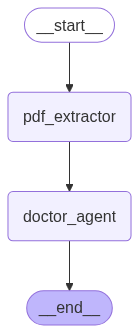

: 

In [ ]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error visualizing graph: {e}")

In [60]:
input_state = {
    "file_path": "001000000000084296_001_250571278_C10_117_1.pdf",
    "messages": []
}

final_state = app.invoke(input_state)

print("✅ Final Report Analysis:\n")
print(final_state["insights"])



> Entering new AgentExecutor chain...
Thought: I need to extract the text content from the PDF file.  
Action: extract_report_text  
Action Input: 001000000000084296_001_250571278_C10_117_1.pdf  Clinical Chemistry ReportPDF: 01-May-2025 11:30:46
MBBS, DABP (AP and 
Cytopathology), FIAC
MBBS, DABP (AP, CP and 
Hematopathology)
MBBS, DABP (AP, CP, 
Cytopathology)
Dr. Asif Loya Dr. Asad Hayat Ahmad Dr. Umer Nisar Sheikh
Electronically verified report, no signature(s) required.
Department of Pathology
Shaukat Khanum Memorial Cancer Hospital & Research Centre
Johar Town, Lahore, Pakistan. Phone: +92-42-35905000, 111-155-555, Fax: 042-35945198
Email: info@skm.org.pk, Website: www.shaukatkhanum.org.pk
Page 1 of 1
Chemistry I - Serum
CREATININE
eGFR
GLUCOSE (FASTING)*
TEST(s)
0.60 - 1.10
>60
70 - 99
NORMAL 01-MAY-2025 
11:26:37
mg/dL
mL/min/1.73 
m²
mg/dL
UNIT(s)
021RCH25006893
0.66
94.87
111
001-80003010010MRNO :
: 13- JUL- 1975Date of Birth
Samina AmjadName :
Phone 92 0300 8655387:
In-hous